<center>
    
# Crop Yield Prediction Project
    
</center>

## Objective
The primary objective of this project is to develop a machine learning model capable of accurately predicting crop yield based on environmental and agricultural factors. Leveraging Random Forest Regression, the goal is to build a predictive system using a dataset sourced from Kaggle.

### 1. Import relevant packages

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

### 2. Load the dataset

In [9]:
df = pd.read_csv('crop_yield.csv')
df.head()

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251


### 3. Exploratory Analysis

In [10]:
df.describe()

,Rainfall_mm,Temperature_Celsius,Days_to_Harvest,Yield_tons_per_hectare
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,549.981901,27.504965,104.495025,4.649472
std,259.851320,7.220608,25.953412,1.696572
min,100.000896,15.000034,60.000000,-1.147613
25%,324.891090,21.254502,82.000000,3.417637
50%,550.124061,27.507365,104.000000,4.651808
75%,774.738520,33.753267,127.000000,5.879200
max,999.998098,39.999997,149.000000,9.963372


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Region                  1000000 non-null  object 
 1   Soil_Type               1000000 non-null  object 
 2   Crop                    1000000 non-null  object 
 3   Rainfall_mm             1000000 non-null  float64
 4   Temperature_Celsius     1000000 non-null  float64
 5   Fertilizer_Used         1000000 non-null  bool   
 6   Irrigation_Used         1000000 non-null  bool   
 7   Weather_Condition       1000000 non-null  object 
 8   Days_to_Harvest         1000000 non-null  int64  
 9   Yield_tons_per_hectare  1000000 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 62.9+ MB


The dataset has features with numeric, categorical and boolean values.

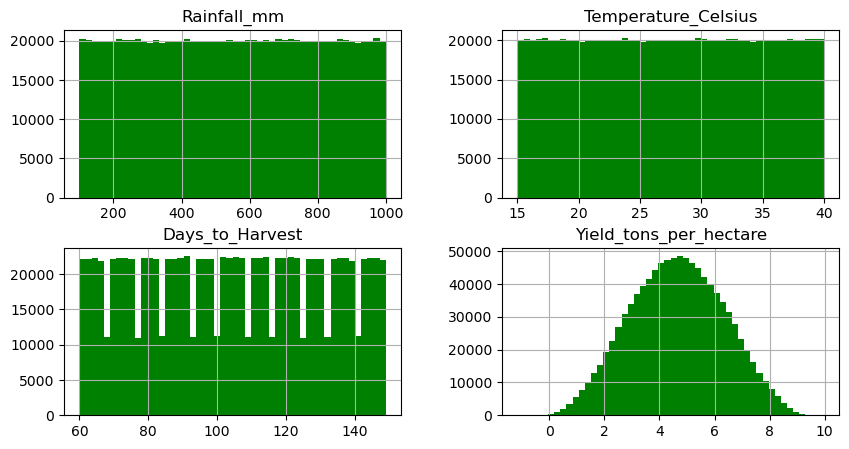

In [12]:
#visualize the ditribution of the numeric columns
df.hist(bins=50, figsize=(10,5), color='green')
plt.show()

- The visuals of the rainfall and temperature features show a uniform distribution. This suggests consistent rainfall and temperature across different observations.
- For the 'Days to Harvest' feature, the histogram shows a discontinuous distribution with noticeable, evenly spaced gaps, suggesting a preference for specific harvesting periods while skipping intermediate values.
- The yield(tons per hectare), which is the target variable follows a normal distribution, suggesting that most values cluster around a central mean with symmetrical variation.

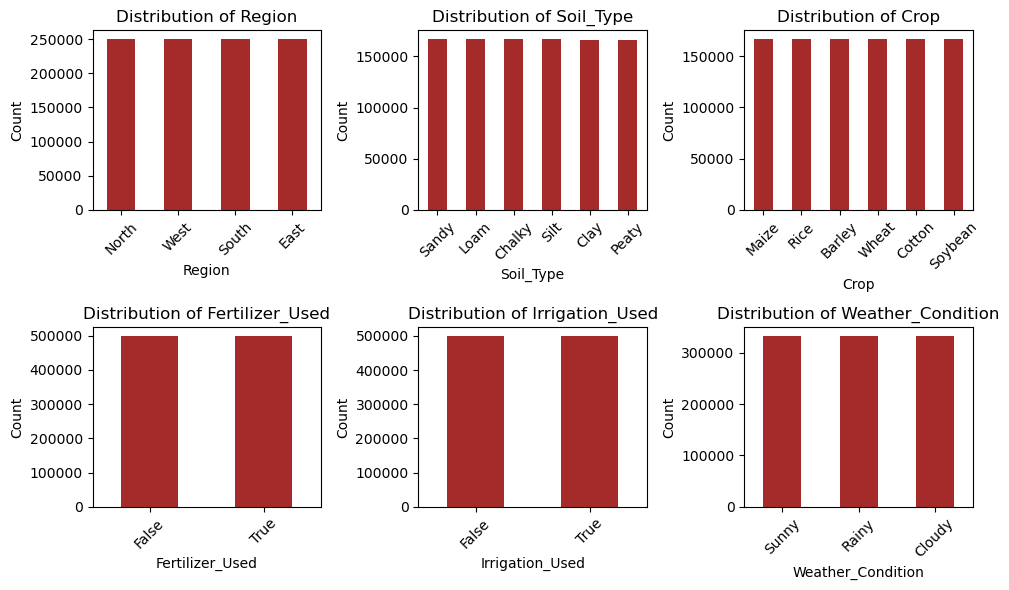

In [14]:
#visualize the ditribution of the numeric columns

# Select categorical and boolean columns
non_numeric_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns

# Create subplots with 3 columns
n_cols = 3
n_rows = (len(non_numeric_cols) + n_cols - 1) // n_cols  # Calculate rows based on number of columns

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))

# Loop through each column and plot separately
for i, col in enumerate(non_numeric_cols):
    ax = axes[i // n_cols, i % n_cols]
    df[col].value_counts().plot(kind='bar', ax=ax, color='brown')
    ax.set_title(f"Distribution of {col}")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(len(non_numeric_cols), n_rows * n_cols):
    axes[j // n_cols, j % n_cols].axis('off')

plt.tight_layout()
plt.show()

All non-numeric columns show uniform disribution. This means they are evenly spread

In [15]:
# Checking for missing values
df.isnull().sum()

Region                    0
Soil_Type                 0
Crop                      0
Rainfall_mm               0
Temperature_Celsius       0
Fertilizer_Used           0
Irrigation_Used           0
Weather_Condition         0
Days_to_Harvest           0
Yield_tons_per_hectare    0
dtype: int64

The dataset has no null values

In [17]:
# Checking feature correlation

# Apply Label Encoding to categorical and boolean columns
categorical_bool_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns  
le = LabelEncoder()

for col in categorical_bool_cols:
    df[col] = le.fit_transform(df[col])
    
corr = df.corr()
corr['Yield_tons_per_hectare']

Region                    0.000390
Soil_Type                -0.000333
Crop                      0.001283
Rainfall_mm               0.764618
Temperature_Celsius       0.085565
Fertilizer_Used           0.442099
Irrigation_Used           0.353741
Weather_Condition         0.001132
Days_to_Harvest          -0.002591
Yield_tons_per_hectare    1.000000
Name: Yield_tons_per_hectare, dtype: float64

<Axes: >

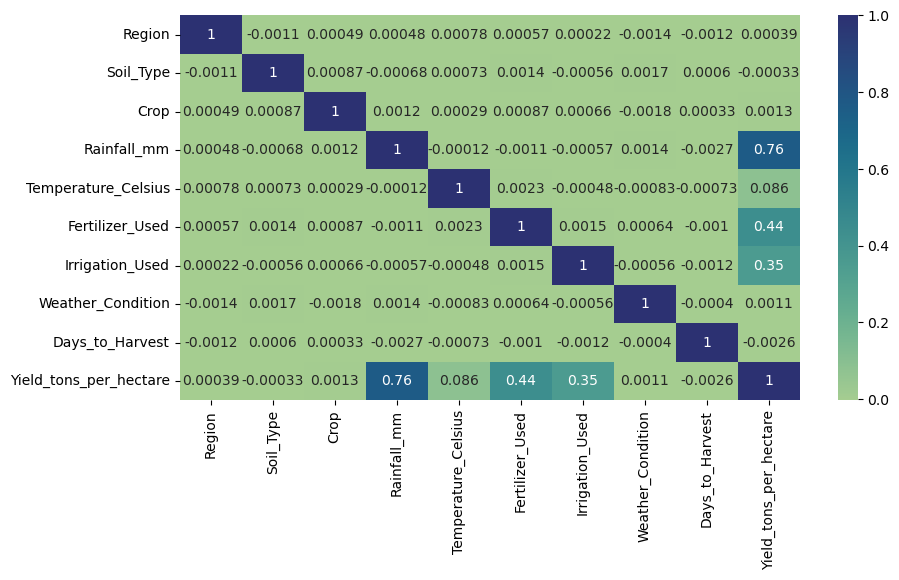

In [18]:
## Visualizing correlation

plt.figure(figsize=(10,5))

sns.heatmap(corr,annot=True,cmap='crest')

The heatmap and correlation values indicate that rainfall (0.76), fertilizer use (0.44), and irrigation (0.35) have the strongest positive relationships with yield, suggesting they significantly influence productivity.

### 4. Data Preprocessing

In [19]:
# Split data into features and target
X = df.drop('Yield_tons_per_hectare', axis=1)
Y = df['Yield_tons_per_hectare']

In [20]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [21]:
# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled,Y, test_size=0.3,random_state=42)

print('The size of training data is: {} \nThe size of testing data is: {}'.format(len(X_train), len(X_test)))

The size of training data is: 700000 
The size of testing data is: 300000


### 4. Model Selection & Training

In [22]:
RF_reg = RandomForestRegressor(n_estimators=20, max_depth=10, min_samples_split=20,bootstrap=False, random_state=42,n_jobs=-1)
RF_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=10, min_samples_split=20,
                      n_estimators=20, n_jobs=-1, random_state=42)

### 5. Model Evaluation

In [23]:
# Predict on the test set
y_pred = RF_reg.predict(X_test)

In [25]:
# mse, rmse and r2_score
r2_value = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"r2 Score: {r2_value}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

r2 Score: 0.9119681666581414
MSE: 0.2540144649341974
RMSE: 0.5039984771149585


### 6. Feature Importance

In [30]:
FI = RF_reg.feature_importances_

FI_df = pd.DataFrame({
    'Feature': X.columns,
    'Feature Importance': FI
})

pd.DataFrame(FI_df)

,Feature,Feature Importance
0,Region,0.000004
1,Soil_Type,0.000009
2,Crop,0.000011
3,Rainfall_mm,0.640679
4,Temperature_Celsius,0.008137
5,Fertilizer_Used,0.214304
6,Irrigation_Used,0.136815
7,Weather_Condition,0.000003
8,Days_to_Harvest,0.000039


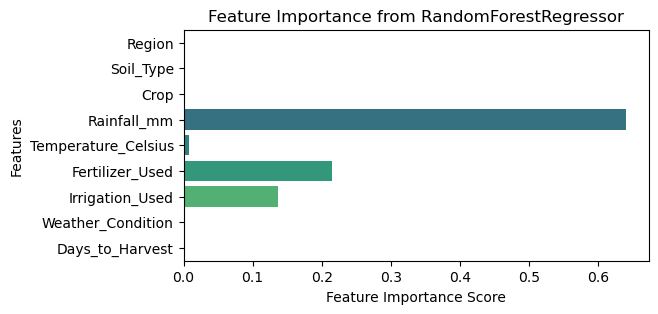

In [31]:
#  Visualize feature importance

plt.figure(figsize=(6, 3))
sns.barplot(x="Feature Importance", y="Feature", data=FI_df,
            palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance from RandomForestRegressor")
plt.show()

## Save Model

In [32]:
with open("crop_yield_pred.pkl", "wb") as file:
    pickle.dump(RF_reg, file)

In [33]:
with open("crop_yield_pred.pkl", "rb") as file:
    loaded_model = pickle.load(file)

In [39]:
X[X['Crop']==1]

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest
0,3,4,1,897.077239,27.676966,0,1,0,122
11,0,4,1,145.300681,19.755535,1,1,0,141
12,2,3,1,607.150252,15.562163,1,1,2,136
17,1,1,1,416.898632,23.190810,1,1,2,95
20,0,1,1,990.267439,24.072052,0,1,2,110
...,...,...,...,...,...,...,...,...,...
999973,1,3,1,217.387025,27.306320,0,0,0,137
999974,2,2,1,528.002127,37.384126,0,1,1,62
999976,1,0,1,959.604272,32.334733,0,0,0,109
999979,2,2,1,315.605610,30.119779,1,1,0,118


In [43]:
with open("crop_yield_pred.pkl", "rb") as f:
    encoders = pickle.load(f)

# Example: Get encoding for 'Region'
print(encoders['Region'].classes_)

TypeError: list indices must be integers or slices, not str